# Linear Inverse Reinforcement Learning - Mountain Car

Linear IRL algorithm in the case:

1. We have access to the policy $\pi$ only throu
2. The dynamics of the environment are not known to the agent. 

For  more details on the algorithm, refer to Section 5 of [Algorithms for Inverse Reinforcement Learning](https://ai.stanford.edu/~ang/papers/icml00-irl.pdf) paper.

In [1]:
from IPython.display import HTML
%matplotlib inline

import gym
import itertools
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler
import scipy

from rl_agents.q_learning import *

## The Environment - Mountain Car
![alt text](images/1_nbCSvWmyS_BUDz_WAJyKUw.gif "Mountain Car")


In [2]:
# Gym Environment
env = gym.make("MountainCar-v0").env
print("Continuous State Space:")
print('\tObservation (state) space:', env.observation_space)
print('\tSample random observation:', env.observation_space.sample())
print('\tObservation low:', env.observation_space.low)
print('\tObservation high:', env.observation_space.high)
print("")
print("Discrete Action Space:")
print('\tAction space:', env.action_space)
print('\tSample random action:', env.action_space.sample())
print("")
print('Reward range:', env.reward_range)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Continuous State Space:
	Observation (state) space: Box(2,)
	Sample random observation: [-0.2121357   0.03012651]
	Observation low: [-1.2  -0.07]
	Observation high: [0.6  0.07]

Discrete Action Space:
	Action space: Discrete(3)
	Sample random action: 1

Reward range: (-inf, inf)


/Users/shahil/miniconda3/envs/rl/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


## Creating observation set of the state values

In [3]:
observation_examples= np.array([env.observation_space.sample() for x in range(10000)])
print("First five observations:")
for o in range(5):
    print(observation_examples[o])

First five observations:
[-0.07758535 -0.01618656]
[-0.6644377  -0.06206018]
[-0.7092187  -0.00312688]
[ 0.26190373 -0.0028032 ]
[-0.4929874   0.04705103]


## Normalise observation set

In [4]:
def normalisation(observation_examples):
    """
    Calculates Mean and Variance of the state values
    
    Args:
        observation_examples: An array of 10000 random state::[position, velocity] values.
    Returns:
        Mean and variance of the state values.
    """
    distribution_props = sklearn.preprocessing.StandardScaler()
    distribution_props.fit(observation_examples)
    return distribution_props

In [5]:
distribution_props = normalisation(observation_examples)
print("Distribution Mean:",distribution_props.mean_)
print("Distribution Variance:",distribution_props.var_)
print("")
normalised_data = distribution_props.fit_transform(observation_examples)
print("First five normalised observations:")
for o in range(5):
    print(normalised_data[o])

Distribution Mean: [-3.01855176e-01 -3.31797823e-06]
Distribution Variance: [0.26813763 0.00163398]

First five normalised observations:
[ 0.43310377 -0.4003516 ]
[-0.7002095 -1.5352031]
[-0.7866893 -0.0772728]
[ 1.0887158 -0.0692652]
[-0.36910933  1.1640611 ]


##  Extract features
* Radial basis function kernels are used for feature extraction

For  more details on the algorithm, refer to [sklearn RBFSampler](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html)

In [6]:
def featuriser(normalised_data):
    """
    Extract features from normalised_data
    
    Args:
        normalised_data: An array of 10000 normalised state::[position, velocity] values.
    Returns:
        Container for ϕ vector.
    """
    # Container for ϕ vector(Basis vector).[In the paper, they used 26 evenly spaced Gaussian shaped basis functions]
    featuriser_vector = sklearn.pipeline.FeatureUnion([
        ("rbf1",RBFSampler(gamma=0.5,n_components=10)),
        ("rbf2", RBFSampler(gamma=0.25, n_components=20)),
        ("rbf3", RBFSampler(gamma=0.1, n_components=20))
    ])
    
    # Reward dependency on position value only.
    position_vec = np.delete(normalised_data, 1,1)
    # Fit method defines the upper and lower limits of random offset and fits the data
    featuriser_vector.fit(position_vec)
    
    return featuriser_vector

In [7]:
# Feature vector Container 
featuriser_vector = featuriser(normalised_data)
print(featuriser_vector)

FeatureUnion(n_jobs=None,
       transformer_list=[('rbf1', RBFSampler(gamma=0.5, n_components=10, random_state=None)), ('rbf2', RBFSampler(gamma=0.25, n_components=20, random_state=None)), ('rbf3', RBFSampler(gamma=0.1, n_components=20, random_state=None))],
       transformer_weights=None)


## Generate Alpha Vector (randomly initialised)

In [8]:
def RandomVectorGenerator(featureVecDim=50):
    return 2*np.random.rand(featureVecDim)-1

In [9]:
featureVecDim = 50        # paper used 26  

# Defining Alpha_vec α=[α0 α1 ... αn]
alpha_vec = RandomVectorGenerator(featureVecDim)  
print("Random Alpha Vector: ")
print(alpha_vec)

Random Alpha Vector: 
[-0.15916131  0.49199248  0.08498945  0.05129997  0.22791614  0.27235719
  0.22864058  0.64834247  0.10387926  0.91844912  0.59488438  0.5375456
  0.350374    0.79594509 -0.47171535 -0.31422474  0.24480258  0.63957544
 -0.87664436  0.65035216  0.50039576  0.04347197 -0.07649143 -0.0985937
 -0.74127857 -0.73107212  0.09617838  0.14987623  0.14934429 -0.3903863
 -0.82782558 -0.08887161  0.54002671  0.24409027 -0.23714729 -0.41305936
  0.16996576  0.72294292 -0.25294115 -0.08163773  0.81994824 -0.25271338
 -0.12124218  0.08110221  0.53538696 -0.09065488  0.1107234  -0.16633952
  0.65578965  0.53922767]


## Reward

In [10]:
def scaler_val(state, distribution_props):
    return (state[0]- distribution_props.mean_[0])/distribution_props.var_[0]

In [11]:
def reward(alpha_vec, featuriser_vector, distribution_props):
    def reward_fn(state):
        return np.dot(alpha_vec, featuriser_vector.transform([[scaler_val(state,distribution_props)]])[0])
    return reward_fn

Helper functions

In [12]:
def UniformRandomPolicyGenerator(nA):
    # nA = number of actions
    def urpg(state):
        return np.ones(nA, dtype=float)/nA
    return urpg

In [13]:
def max_dict(dictionary):
    v_max=max(dictionary.values())
    for key, value in dictionary.items():
        if value == v_max:
            return key

In [14]:
def e_greedy_policy(estimator, nA,epsilon):
    def policy_maker(observation):
        A=np.ones(nA, dtype=float)*epsilon/nA
        q_values=  estimator.predict(observation)
        best_action=np.argmax(q_values)
        A[best_action] += (1.0-epsilon)
        return A
    return policy_maker

In [15]:
def reward_plot(alpha_vec, featuriser_vector, scaler):
    x=np.linspace(-1.2,0.6,num=1000)
    i=0
    y=np.zeros(1000)
    for position in x:
        y[i] = np.dot(alpha_vec,featuriser_vector.transform([[(position-scaler.mean_[0])/scaler.var_[0]]])[0])
        i+=1
    plt.plot(x,y,linewidth=2.0) 
    plt.xlabel("Position")
    plt.ylabel("Reward")
    plt.title("Reward function")
    plt.show()

## Reinforcement Learning - Q Learning

____Expert Policy Generation____



100%|██████████| 200/200 [01:15<00:00,  3.97it/s]


___Plotting Learning Stats of the Agent____


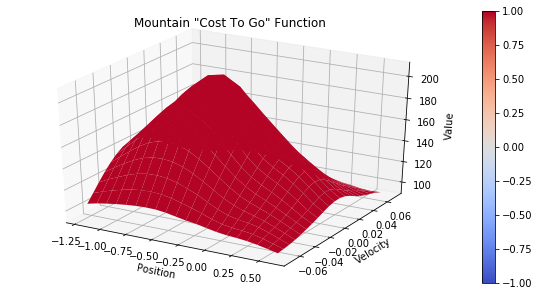

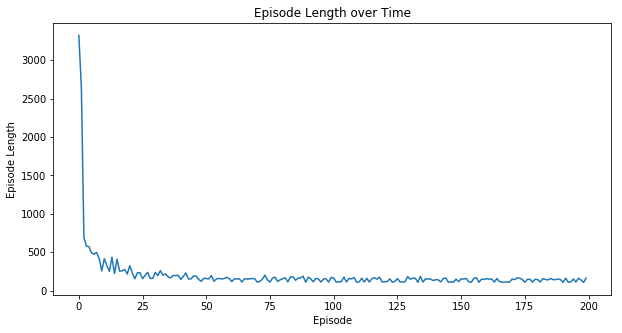

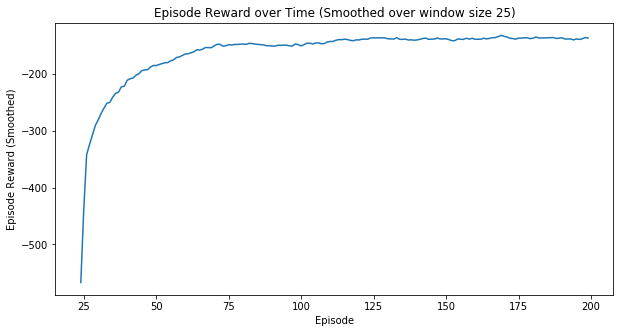

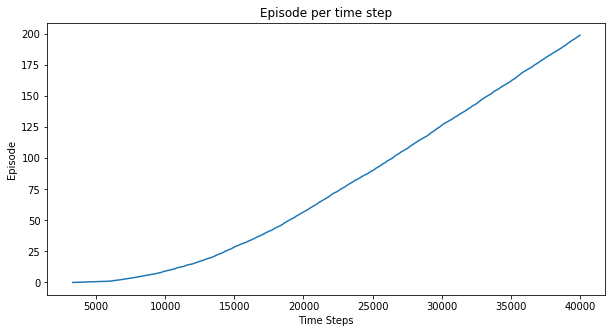

In [16]:
print('____Expert Policy Generation____'+'\n')

featuriser = state_featurizer(normalised_data)
policy_dbe, estimator_dbe = policy_f(env, distribution_props , featuriser, print_ep_lens=False)

## Value Function

We need a way of estimating $V^{\pi}(s_0)$ for any setting of $\alpha_i s$.

In [17]:
def ValueFunctionGenerator(env,alpha_vec, policy, featuriser_vector, distribution_props, featureVecDim, num_trajectories, discount_factor):
    """
    Calculates the value and value vector of the start state: V(𝚜0).
    
    Args:
        env: Gym environment
        alpha_vec: The alpha vector (variable) to be learnt.
        policy: Given a state, it provides the probabilities of each possible action.{π[𝚊i|s]}
        featuriser_vector: The container for basis fuctions.(RBF kernals in this case)
        distribution_props: Mean and variance of the state values.
        featureVecDim: Dimension of ϕ vector.(feature vector/Basis vector)
        num_trajectories: Expert trajectories taken under consideration
    
    Returns:
        Value of the start state V(𝚜0):R(τ)= [α0 α1 .. αn]⋅[𝚅ϕ0 𝚅ϕ1 .. 𝚅ϕn]
        Value vector: [𝚅ϕ0 𝚅ϕ1 ... 𝚅ϕn] where ϕi represents basis functions of feature vector
    
    """
    v_basis= np.zeros(featureVecDim)
    episode = defaultdict(list) 
    for i in range(num_trajectories):
        state= env.reset()
        done =False
        for l in range(200):    
            prob = policy(state)
            action = np.random.choice(np.arange(len(prob)),p=prob)
            next_state, reward, done, _ = env.step(action)
            if done == True:
                break
            episode[i].append((state,action))
            state = next_state
            l+=1
        env.close()
        j=0
        for state, action in episode[i]:
            v_basis += featuriser_vector.transform([[scaler_val(state,distribution_props)]])[0]* (discount_factor)**j 
            j+=1
        
    
    v_basis_net = v_basis/num_trajectories
    V= np.dot(alpha_vec,v_basis_net)
    return V , v_basis_net

In [18]:
def irl(env, alpha_vec,feature_vector, scaler, featuriser, normalised_data, featureVecDim, policy_dbe,num_trajectories=10, num_episodes=20, max_epoch=10, discount_factor=1, penalty_factor=2, epsilon_v=0.0):
    """
    The algorithm to learn a reward function given expert policy/trajectories.
    
    Args:
        env: Gym environment
        alpha_vec: The alpha vector (variable) to be learnt.
        feature_vector: The container for basis fuctions(RBF kernals in this case).
        scaler: Mean and variance of the state values.
        featuriser: The container used for generating expert trajectories.
        normalised_data: An array of 10000 normalised state::[position, velocity] values.
        featureVecDim: Dimension of ϕ vector.(feature vector/Basis vector)
        policy_dbe: "Demostration by expert" policy.==Expert policy
        num_trajectories: Expert trajectories taken under consideration
        num_episodes: Number of episodes for which the RL code is run. 
        max_iter: Maximum number of episodes
        penalty_factor: Refer the paper for more details
        epsilon_v: ϵ value for Epsilon greedy policy
        
    Returns:
        Reward Function R(s).
        Alpha Vector: α = [α0 α1 .. αn]
    """
    # Initialising Variables
    nP=0                                    # number of epochs
    V_vec = defaultdict(float)
    V_policy_basis = defaultdict(list)
    V_input = np.zeros(featureVecDim)
    
    # Calculating V* value for the best DBE policy that we already have.
    V_dbe, V_dbe_basis = ValueFunctionGenerator(env,alpha_vec, policy_dbe,feature_vector,scaler,featureVecDim, num_trajectories, discount_factor)
    print("-------------------------------")
    print("| V_dbe | ",V_dbe," |")
    print("-------------------------------")
    print("")
    
    # Iterating part of the code : new learnt policy with each new iteration
    
    while True:
        print("############################################################################")
        print("Starting epoch {} .... ".format(nP))
        print("Alpha_vec value at the start of the epoch = {}".format(alpha_vec)) 
        
        # Uniform Random policy
        if nP ==0:
            policy_ = UniformRandomPolicyGenerator(env.action_space.n)
        
        V_vec[nP], V_policy_basis[nP] = ValueFunctionGenerator(env,alpha_vec, policy_,feature_vector,scaler,featureVecDim,num_trajectories, discount_factor)
        print("New policy value based on previous alpha, V_vec[np] = {}".format(V_vec[nP]))
    
    
        # Linear Programming optimisation
        print("_____________________________LP starts_______________________________")
        
        # nP_best: Iteration with the max value according to the present alpha_vec.
        nP_best = max_dict(V_vec)
        
        print("nP_best =", nP_best)
        print("nP_best_value based on old alpha =", V_vec[nP_best])
        print("DBE_value based on old alpha =", V_dbe)
        
        if V_dbe - V_vec[nP] >= 0:
            V_input += V_policy_basis[nP] - V_dbe_basis
        else:
            V_input += penalty_factor* (V_policy_basis[nP] - V_dbe_basis)
        
        res = scipy.optimize.linprog(V_input, bounds=(-1,1), method="simplex")
        
        print("**********LP results******************************************************")
        print("                       ")
        #print(res)
        print("new alpha_vec = ", res.x)
        print("                       ")
        print("**************************************************************************")
        
        alpha_vec_new = res.x
        
        # New V-dbe value based on new alpha
        V_dbe_new = np.dot(alpha_vec_new,V_dbe_basis)
        
        # Updating old values with new values
        alpha_vec = alpha_vec_new
        V_dbe = V_dbe_new
        
        # Editing v_vec values based on new alpha
        for i,list_ in V_policy_basis.items():
            V_vec[i] = np.dot(list_,alpha_vec)
        
        print("According to new alpha, V_dbe = ", V_dbe_new)
        print("New V_vec[max] in existing values", V_vec[max_dict(V_vec)])
        print("_________________________________________________________________________")
        print("Plotting reward function based on alpha_vec start value.....")
        
        reward_plot(alpha_vec, feature_vector,scaler)

        # Reinforcement learning using the learnt reward function to generate new policy
        
        print("Q learning starts..........")
        # Given the new alpha_vec, update the rewards function and find a new policy
        reward_fn = reward(alpha_vec,feature_vector,scaler)
        nP +=1
        
        estimator = Estimator(env,scaler,featuriser)
        min_iter_length = q_learning(env, estimator, reward_fn, num_episodes,print_ep_details=False) 
        policy_ = e_greedy_policy(estimator, env.action_space.n,epsilon_v)
        """
        ** For printing iterations with number of timesteps it took, set 
        {print_ep_details=True} in q_learning().Highly Suggested for starting analysis.
        """
    
        if nP > max_epoch:
            break
        print("############################################################################")
    
    
    return reward_fn, alpha_vec


____IRL____

-------------------------------
| V_dbe |  -67.15768918997644  |
-------------------------------

############################################################################
Starting epoch 0 .... 
Alpha_vec value at the start of the epoch = [ 8.21836335e-03 -1.42173784e-01  6.52679211e-03 -3.36275785e-01
  7.02138291e-01  2.96049571e-01  4.78545885e-01 -3.31779718e-01
 -8.79821535e-01 -3.28498112e-01 -8.46988024e-01 -3.22565698e-01
  8.99471081e-02 -9.47744965e-01 -9.23928903e-01 -6.35751496e-01
  4.61963031e-01  7.53651334e-01 -9.95618111e-01  9.22654298e-01
  6.72421940e-01 -2.24974289e-01 -8.81597929e-01  4.56204691e-01
 -4.68326190e-01 -2.95204226e-01  3.03802838e-02 -1.91954535e-01
  1.29059948e-01 -2.47045463e-01  7.55193967e-01 -7.00988681e-01
 -2.28761800e-01  6.29379603e-01 -1.83130509e-01  9.70828742e-01
 -7.06742396e-01 -5.46121901e-04 -7.09770677e-01  7.04400568e-01
  7.81996087e-01  5.65034550e-01 -6.46342060e-01 -2.83825022e-01
  8.44500424e-02  9.58701887e

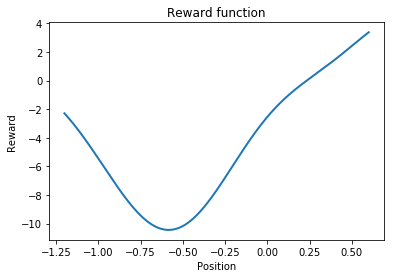

  0%|          | 0/20 [00:00<?, ?it/s]

Q learning starts..........


100%|██████████| 20/20 [00:15<00:00,  2.39it/s]


############################################################################
############################################################################
Starting epoch 1 .... 
Alpha_vec value at the start of the epoch = [-1.  1.  1. -1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.]
New policy value based on previous alpha, V_vec[np] = -1738.3123685591204
_____________________________LP starts_______________________________
nP_best = 1
nP_best_value based on old alpha = -1738.3123685591204
DBE_value based on old alpha = -760.454635085169
**********LP results******************************************************
                       
new alpha_vec =  [-1. -1.  1. -1.  1.  1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1. -1.
 -1. -1. -1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1. 

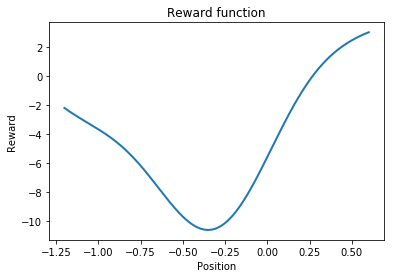

  0%|          | 0/20 [00:00<?, ?it/s]

Q learning starts..........


100%|██████████| 20/20 [00:16<00:00,  2.65it/s]


############################################################################
############################################################################
Starting epoch 2 .... 
Alpha_vec value at the start of the epoch = [-1. -1.  1. -1.  1.  1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1. -1.
 -1. -1. -1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.]
New policy value based on previous alpha, V_vec[np] = -1450.2598960306777
_____________________________LP starts_______________________________
nP_best = 2
nP_best_value based on old alpha = -1450.2598960306777
DBE_value based on old alpha = -729.8233093259139
**********LP results******************************************************
                       
new alpha_vec =  [-1.  1.  1. -1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.

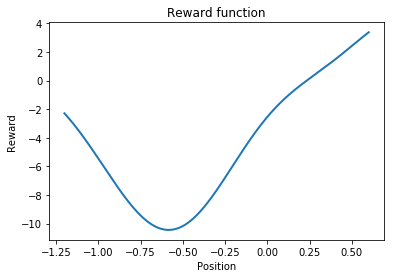

  0%|          | 0/20 [00:00<?, ?it/s]

Q learning starts..........


100%|██████████| 20/20 [00:14<00:00,  2.34it/s]


############################################################################
############################################################################
Starting epoch 3 .... 
Alpha_vec value at the start of the epoch = [-1.  1.  1. -1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.]
New policy value based on previous alpha, V_vec[np] = -1695.7762434810331
_____________________________LP starts_______________________________
nP_best = 3
nP_best_value based on old alpha = -1695.7762434810331
DBE_value based on old alpha = -760.454635085169
**********LP results******************************************************
                       
new alpha_vec =  [-1. -1.  1. -1.  1.  1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1. -1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1. 

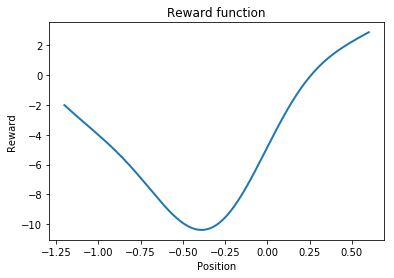

  0%|          | 0/20 [00:00<?, ?it/s]

Q learning starts..........


100%|██████████| 20/20 [00:15<00:00,  2.45it/s]


############################################################################
############################################################################
Starting epoch 4 .... 
Alpha_vec value at the start of the epoch = [-1. -1.  1. -1.  1.  1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1. -1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.]
New policy value based on previous alpha, V_vec[np] = -1746.4662928468608
_____________________________LP starts_______________________________
nP_best = 2
nP_best_value based on old alpha = -1552.325211334328
DBE_value based on old alpha = -741.9979246159439
**********LP results******************************************************
                       
new alpha_vec =  [-1.  1.  1. -1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1. 

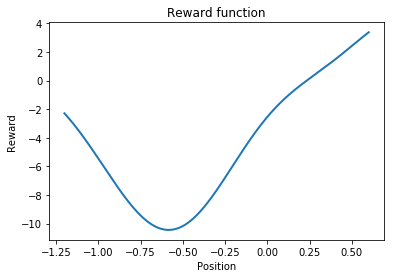

  0%|          | 0/20 [00:00<?, ?it/s]

Q learning starts..........


100%|██████████| 20/20 [00:17<00:00,  2.27it/s]


############################################################################
############################################################################
Starting epoch 5 .... 
Alpha_vec value at the start of the epoch = [-1.  1.  1. -1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.]
New policy value based on previous alpha, V_vec[np] = -880.7164284204359
_____________________________LP starts_______________________________
nP_best = 5
nP_best_value based on old alpha = -880.7164284204359
DBE_value based on old alpha = -760.454635085169
**********LP results******************************************************
                       
new alpha_vec =  [-1.  1.  1. -1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1

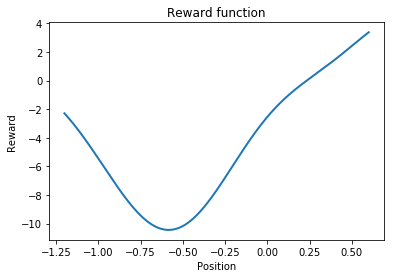

  0%|          | 0/20 [00:00<?, ?it/s]

Q learning starts..........


100%|██████████| 20/20 [00:15<00:00,  2.05it/s]


############################################################################
############################################################################
Starting epoch 6 .... 
Alpha_vec value at the start of the epoch = [-1.  1.  1. -1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.]
New policy value based on previous alpha, V_vec[np] = -1407.6677417784115
_____________________________LP starts_______________________________
nP_best = 5
nP_best_value based on old alpha = -880.7164284204359
DBE_value based on old alpha = -760.454635085169
**********LP results******************************************************
                       
new alpha_vec =  [-1.  1.  1. -1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  

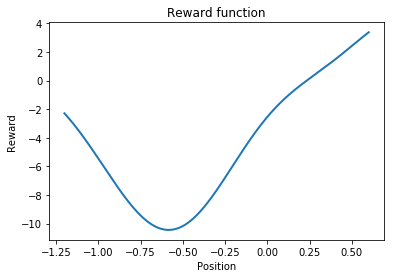

  0%|          | 0/20 [00:00<?, ?it/s]

Q learning starts..........


100%|██████████| 20/20 [00:15<00:00,  2.10it/s]


############################################################################
############################################################################
Starting epoch 7 .... 
Alpha_vec value at the start of the epoch = [-1.  1.  1. -1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.]
New policy value based on previous alpha, V_vec[np] = -1728.369917109174
_____________________________LP starts_______________________________
nP_best = 5
nP_best_value based on old alpha = -880.7164284204359
DBE_value based on old alpha = -760.454635085169
**********LP results******************************************************
                       
new alpha_vec =  [-1. -1.  1. -1.  1.  1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1. -1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1

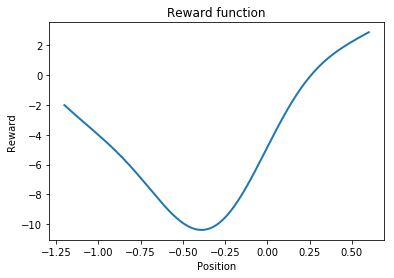

  0%|          | 0/20 [00:00<?, ?it/s]

Q learning starts..........


100%|██████████| 20/20 [00:17<00:00,  2.08it/s]


############################################################################
############################################################################
Starting epoch 8 .... 
Alpha_vec value at the start of the epoch = [-1. -1.  1. -1.  1.  1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1. -1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.]
New policy value based on previous alpha, V_vec[np] = -1054.0196999510777
_____________________________LP starts_______________________________
nP_best = 5
nP_best_value based on old alpha = -846.9408609450296
DBE_value based on old alpha = -741.9979246159439
**********LP results******************************************************
                       
new alpha_vec =  [-1. -1.  1. -1.  1.  1. -1. -1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1. 

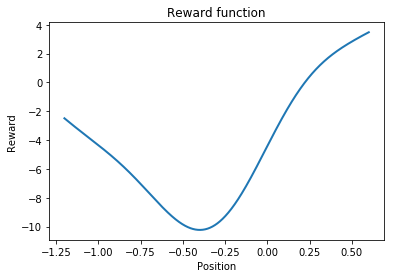

  0%|          | 0/20 [00:00<?, ?it/s]

Q learning starts..........


100%|██████████| 20/20 [00:15<00:00,  2.27it/s]


############################################################################
############################################################################
Starting epoch 9 .... 
Alpha_vec value at the start of the epoch = [-1. -1.  1. -1.  1.  1. -1. -1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.]
New policy value based on previous alpha, V_vec[np] = -1289.6660086073362
_____________________________LP starts_______________________________
nP_best = 5
nP_best_value based on old alpha = -833.8969346109179
DBE_value based on old alpha = -732.1017717724878
**********LP results******************************************************
                       
new alpha_vec =  [-1. -1.  1. -1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1. 

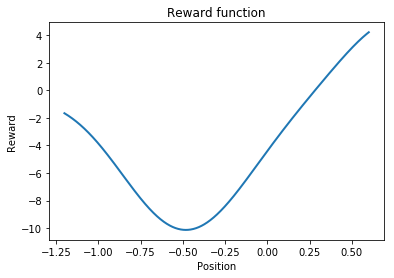

  0%|          | 0/20 [00:00<?, ?it/s]

Q learning starts..........


100%|██████████| 20/20 [00:15<00:00,  2.24it/s]


############################################################################
############################################################################
Starting epoch 10 .... 
Alpha_vec value at the start of the epoch = [-1. -1.  1. -1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.]
New policy value based on previous alpha, V_vec[np] = -1910.4883497241408
_____________________________LP starts_______________________________
nP_best = 5
nP_best_value based on old alpha = -866.0818985087258
DBE_value based on old alpha = -748.5759511789596
**********LP results******************************************************
                       
new alpha_vec =  [-1. -1.  1. -1.  1.  1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1. -1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.

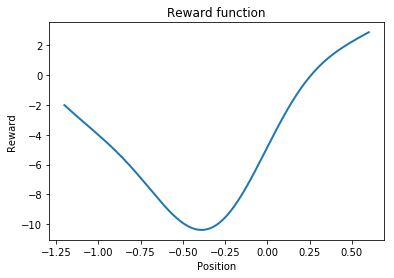

  0%|          | 0/20 [00:00<?, ?it/s]

Q learning starts..........


100%|██████████| 20/20 [00:18<00:00,  2.03it/s]


In [19]:
# IRL Main Code
print('\n'+'____IRL____'+'\n')
reward_fn, alpha_vec = irl(env, alpha_vec, featuriser_vector,distribution_props,featuriser, normalised_data,featureVecDim, policy_dbe)


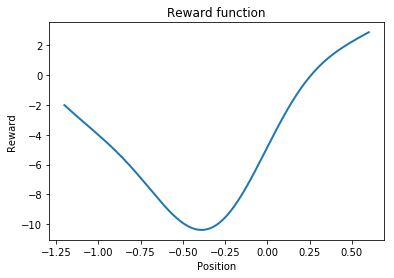

  0%|          | 0/200 [00:00<?, ?it/s]

Q-learning starts:


100%|██████████| 200/200 [01:11<00:00,  3.23it/s]


Final results in graphs and 3D visualisation:


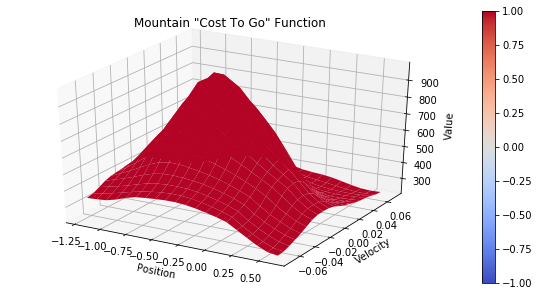

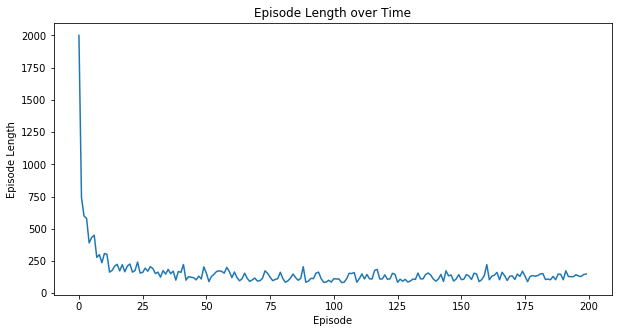

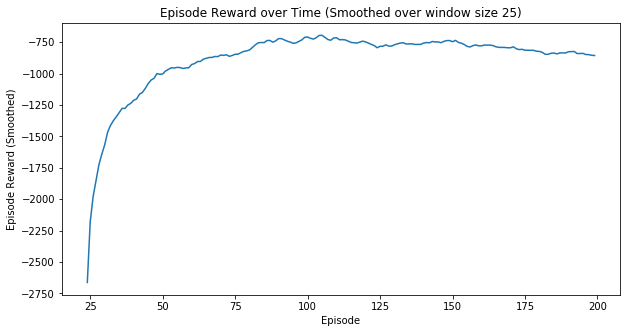

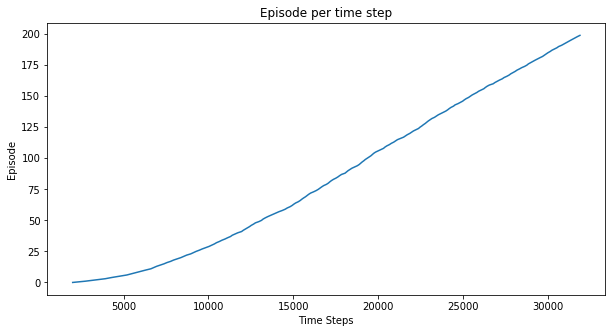

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [20]:
"""
Code Block generating stats for agent trained through learnt reward function.
"""
estimator_f = Estimator(env, distribution_props, featuriser)
reward_plot(alpha_vec, featuriser_vector, distribution_props)
print("Q-learning starts:")
"""
** For printing iterations with number of timesteps required, set {print_ep_details=True} in q_learning_testing_rewards().
Highly Suggested for starting analysis.
"""
success = q_learning_testing_rewards(env, estimator_f, reward_fn , num_episodes=200,render=False,ep_details=False)

print("Final results in graphs and 3D visualisation:")
plotting.plot_cost_to_go_mountain_car(env, estimator_f)
plotting.plot_episode_stats(success, smoothing_window=25)

100%|██████████| 100/100 [00:21<00:00,  5.11it/s]


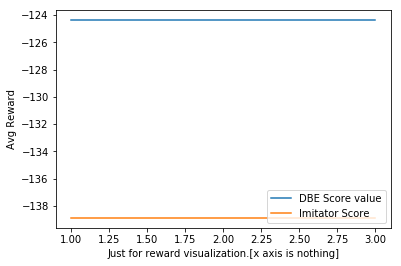

Expert policy score   |  -124.39
Imitator policy score |  -138.87


In [21]:
a,b = compare_results(env,estimator_f,estimator_dbe,num_test_trajs=100,epsilon_test=0.0)

# Comments on the Final results

- The reward function learnt may be different everytime. The reason is the issue of degeneracy & is clearly explained in the [IRL](https://ai.stanford.edu/~ang/papers/icml00-irl.pdf) paper. 


- The Ideal results that is expected is `Expert policy score >= Imitator Policy score`. The **expert score** ranges between `[-150,-100]` and the **imitator score** must be as near to the Expert score indicating it learnt as great the imitator. But, that's not the case everytime. There are cases where:
    - Imitator Score is quite worse compared to Expert Score.
    - Imitator score is better than Expert Score.
    - Expert score is lower than -180.
    - Reward function learning diverges. (very rare but happens with some hyperparameter combinations)


- The main reason behind the exception cases is the fact that the starting position of the car is random between [-0.6,-0.4], which causes _variations_ in the trajectory data. As we used a linear approximator, its not good a function approximator compared to neural networks. The two ways to make sure such cases occur the least are:
    - Change the random start state line in the environment code. (Optional - To be clear, all results were generated on non-edited mountain car env)
    - Increase the value of `num_trajectories`. (Optimal observed was 10)

# Further Work:

- Need to use `l1 norm` in the LP optimisation in addition with the original optimisation. It was explained in the paper that it may help solve the key issue of degeneracy, the existance of large set of reward functions for which the observed policy is optimal.


- Need to normalise learnt reward function beetween `[-1,0]`. I believe that bounding the reward function may help in better learning of reward function.